In [6]:
import numpy as np
from PIL import Image
import json
import os
import time
from glob import glob


Classes = ["D00","D10","D20","D40"]
Names = ["Czech","India","Japan"]
Box = [600,720,600]

In [7]:
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [5]:
with open('ensemble1/base_model.json', 'r') as f:
    D = json.load(f)


Ensemble_D = {}


mods = glob('ensemble1/model_*')

for mod_idx in range(len(mods)):
    with open(mods[mod_idx], 'r') as f:
        Ensemble_D[mod_idx] = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'ensemble1/base_model.json'

In [22]:
# Load the ensemble JSONs
with open('ensemble2/model_4_5.json', 'r') as f:
    model_4_5 = json.load(f)
    
with open('ensemble2/model_4_6.json', 'r') as f:
    model_4_6 = json.load(f)
    
with open('ensemble2/model_4_7.json', 'r') as f:
    model_4_7 = json.load(f)

Ensemble_D = [model_4_5, model_4_6, model_4_7]


In [23]:
import numpy as np
import json
from glob import glob

# Classes and bounding box dimensions (use as needed for bounding box adjustments)
Classes = ["D00", "D10", "D20", "D40"]
Box = [600, 720, 600]  # You can adapt this if necessary for different sizes

# Non-Maximum Suppression function
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

# Load the ensemble JSONs
with open('ensemble2/model_4_5.json', 'r') as f:
    model_4_5 = json.load(f)

with open('ensemble2/model_4_6.json', 'r') as f:
    model_4_6 = json.load(f)

with open('ensemble2/model_4_7.json', 'r') as f:
    model_4_7 = json.load(f)

# List to hold all the models
Ensemble_D = [model_4_5, model_4_6, model_4_7]

# Confidence thresholds
con = [0.06, 0.06, 0.11]  # Adjust as needed for your specific task
nm = 1  # Non-max suppression threshold

# Start creating the ensemble prediction
submission = list()
dets = list()

for count in range(len(model_4_5)):  # Loop through the dataset
    line = list()
    boxes = list()

    # Get the file name (assuming the same file is used across models)
    name = model_4_5[count]['filename'].split("/")[-1]  # Get just the image name
    line.append(name)

    # Collect bounding boxes from all models in the ensemble
    for model in Ensemble_D:
        if len(model[count]['objects']) != 0:
            for obj in model[count]['objects']:
                # Add bounding boxes that pass the confidence threshold
                if obj['confidence'] >= con[0]:  # Use a general confidence threshold here
                    idx = Classes.index(obj['name']) + 1  # Class index
                    y = obj['relative_coordinates']['center_y'] * Box[0]
                    x = obj['relative_coordinates']['center_x'] * Box[0]
                    h = obj['relative_coordinates']['height'] * Box[0] * 0.5
                    w = obj['relative_coordinates']['width'] * Box[0] * 0.5

                    # Append box coordinates and confidence to boxes list
                    boxes.append([int(x - w), int(y - h), int(x + w), int(y + h), obj['confidence'], idx])

    # Perform non-maximum suppression (NMS) on the collected boxes
    if len(boxes) > 0:
        boxes = np.array(boxes).reshape(-1, 6)
        keep = nms(boxes, nm)  # Apply NMS to remove duplicates

        for i in keep:
            line.extend([boxes[i, 5], boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3]])

    # Write the result to the output file
    with open("ensemble2_output.txt", "a") as text_file:
        text_file.write(f"{line[0]}, ")
        for a in line[1:]:
            text_file.write(f"{int(a)} ")
        text_file.write("\n")


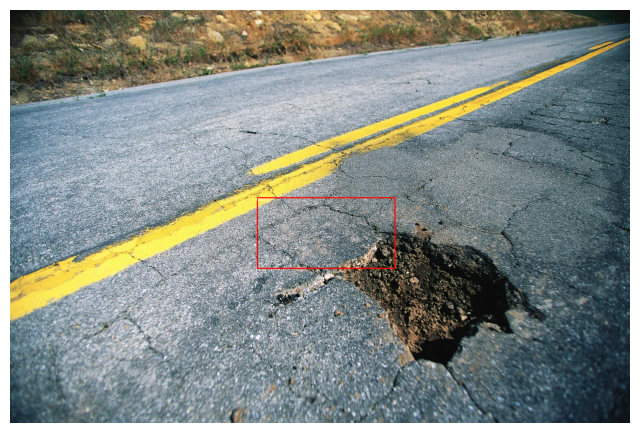

In [25]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Path to your image
image_path = "/home/opryan90/IEEE-Big-Data-2020/image.png"
image = Image.open(image_path)

# Bounding box data from the output
output_data = "image.png 4 637 485 994 669 3 1194 136 1600 472 3 150 118 1618 848"
data = output_data.split(",")[1].strip().split()

# Group the bounding boxes (since the format repeats every 5 items: class, x_min, y_min, x_max, y_max)
bounding_boxes = [data[i:i + 5] for i in range(0, len(data), 5)]

# Create a drawing context
draw = ImageDraw.Draw(image)

# Loop through the bounding boxes and draw them
for box in bounding_boxes:
    class_id, x_min, y_min, x_max, y_max = map(int, box)
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)
    draw.text((x_min, y_min), f"Class {class_id}", fill="white")

# Display the image with bounding boxes using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.show()

# Optionally, save the result
output_image_path = "/home/opryan90/IEEE-Big-Data-2020/image_with_boxes.png"
image.save(output_image_path)


## Test 1

In [18]:
!rm "ensemble1.txt"
con = [0.22,0.16,0.11]
con3 = [0.7,0.7,0.6]
con4 = [0.95,0.95,0.4]
nm = [1,1,1]


submission = list()
dets = list()

for count in range(len(D)):
    line = list()
    boxes = list()

    name = D[count]['filename'].split("/")[-1]
    line.append(name)
    idd = Names.index(name.split("_")[0])

    if (len(D[count]['objects']))!=0:
        for bound in (D[count]['objects']):
            if bound['confidence'] >=con[idd]:
                idx = Classes.index(bound['name']) + 1
                y = bound['relative_coordinates']['center_y']*Box[idd]
                x = bound['relative_coordinates']['center_x']*Box[idd]
                h = bound['relative_coordinates']['height']*Box[idd]*0.5
                w = bound['relative_coordinates']['width']*Box[idd]*0.5

                boxes.append([int(x-w),int(y-h),int(x+w),int(y+h),bound['confidence'],idx])
    
    for mod_idx in range(len(mods)):
        if (len(Ensemble_D[mod_idx][count]['objects']))!=0:
            for bound in (Ensemble_D[mod_idx][count]['objects']):
                if bound['confidence'] >=con3[idd]:
                    idx = Classes.index(bound['name']) + 1
                    y = bound['relative_coordinates']['center_y']*Box[idd]
                    x = bound['relative_coordinates']['center_x']*Box[idd]
                    h = bound['relative_coordinates']['height']*Box[idd]*0.5
                    w = bound['relative_coordinates']['width']*Box[idd]*0.5

                    boxes.append([int(x-w),int(y-h),int(x+w),int(y+h),bound['confidence'],idx])
    
    
    if len(boxes) > 0:
        boxes = np.array(boxes).reshape(-1,6)            
        ore = nms(boxes,nm[idd])
        
        for o in ore:
            line.extend([boxes[o,5],boxes[o,0],boxes[o,1],boxes[o,2],boxes[o,3]])
            

    text_file = open("ensemble1.txt", "a")
    for a in line[0:1]:
        text_file.write(str(a)+",")
    dets.extend(line[1:])


    for a in line[1:]:
        text_file.write('%d' %a)
        text_file.write(' ')

    text_file.write("\n")
    text_file.close()

## Test 2

In [19]:
with open('ensemble2/base_model.json', 'r') as f:
    D = json.load(f)


Ensemble_D = {}


mods = glob('ensemble2/model_*')

for mod_idx in range(len(mods)):
    with open(mods[mod_idx], 'r') as f:
        Ensemble_D[mod_idx] = json.load(f)

In [20]:
!rm "ensemble2.txt"
con = [0.22,0.16,0.11]
con3 = [0.7,0.7,0.6]

nm = [1,1,1]


submission = list()
dets = list()

for count in range(len(D)):
    line = list()
    boxes = list()

    name = D[count]['filename'].split("/")[-1]
    line.append(name)
    idd = Names.index(name.split("_")[0])

    if (len(D[count]['objects']))!=0:
        for bound in (D[count]['objects']):
            if bound['confidence'] >=con[idd]:
                idx = Classes.index(bound['name']) + 1
                y = bound['relative_coordinates']['center_y']*Box[idd]
                x = bound['relative_coordinates']['center_x']*Box[idd]
                h = bound['relative_coordinates']['height']*Box[idd]*0.5
                w = bound['relative_coordinates']['width']*Box[idd]*0.5

                boxes.append([int(x-w),int(y-h),int(x+w),int(y+h),bound['confidence'],idx])
    
    for mod_idx in range(len(mods)):
        if (len(Ensemble_D[mod_idx][count]['objects']))!=0:
            for bound in (Ensemble_D[mod_idx][count]['objects']):
                if bound['confidence'] >=con3[idd]:
                    idx = Classes.index(bound['name']) + 1
                    y = bound['relative_coordinates']['center_y']*Box[idd]
                    x = bound['relative_coordinates']['center_x']*Box[idd]
                    h = bound['relative_coordinates']['height']*Box[idd]*0.5
                    w = bound['relative_coordinates']['width']*Box[idd]*0.5

                    boxes.append([int(x-w),int(y-h),int(x+w),int(y+h),bound['confidence'],idx])
    
    
    if len(boxes) > 0:
        boxes = np.array(boxes).reshape(-1,6)            
        ore = nms(boxes,nm[idd])
        
        for o in ore:
            line.extend([boxes[o,5],boxes[o,0],boxes[o,1],boxes[o,2],boxes[o,3]])
            

    text_file = open("ensemble2.txt", "a")
    for a in line[0:1]:
        text_file.write(str(a)+",")
    dets.extend(line[1:])


    for a in line[1:]:
        text_file.write('%d' %a)
        text_file.write(' ')

    text_file.write("\n")
    text_file.close()